In [1]:
from datasets import load_dataset
from mltb2.transformers import TransformersTokenCounter
from mltb2.text import clean_all_invisible_chars_and_strip
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

In [2]:
df = load_dataset("HuggingFaceH4/ultrachat_200k", split="test_sft").to_pandas()
df

,prompt,prompt_id,messages
0,How does the author propose to fix the problem...,9fb649a870769f4881c647d20d178656f67fc881b2dc0b...,[{'content': 'How does the author propose to f...
1,Rice tolerance to suboptimal low temperatures ...,26afb4f9bffc82fbbfdcaa8f0eec0833780e411799dcee...,[{'content': 'Rice tolerance to suboptimal low...
2,Write a free verse poem about the power of the...,3ab0d0c24777248cbc4aa33971d34e8de9393db1ea0cc1...,[{'content': 'Write a free verse poem about th...
3,Compose a speech about the need for more affor...,5dac3c072ba477af9ed0c71a31a806f307d7ea839a7977...,[{'content': 'Compose a speech about the need ...
4,Write a historical fiction story that is set d...,b750ea229635aa6683e0018abd17f92804376c1b0c474d...,[{'content': 'Write a historical fiction story...
...,...,...,...
23105,Please outline the specific effects and conseq...,cd4db4c670afc4a0c49d27e75f9f8af371f067bdf3beac...,[{'content': 'Please outline the specific effe...
23106,Who are some lesser-known British fashion desi...,499ddc7d5b7b065bd1ac5ea0e80c23cc7e73bacabd8b2b...,[{'content': 'Who are some lesser-known Britis...
23107,The fear that merit pay in public education wi...,b0d90e7abab1ec2d1a5513a369a84129564f689f7890d0...,[{'content': 'The fear that merit pay in publi...
23108,Provide a step-by-step guide on the necessary ...,735401bda405ea21fa8b8ba6bf45d6dd8431b8384870dd...,[{'content': 'Provide a step-by-step guide on ...


In [3]:
# are there duplicates in prompt_id
df["prompt_id"].duplicated().sum()

0

In [4]:
df.iloc[0]["messages"]

array([{'content': 'How does the author propose to fix the problem of science alienation in our educational system? What changes does she suggest should be made to science education? Answer according to: Science education should be split into two tracks.\nSplit K-12 science education into two tracks, for majors and nonmajors.\nThose who want to specialize in science could take math and complex chemistry. Nonmajors would focus on science of the everyday—things like kitchen chemistry and CSI-style crime investigations.\nSome years ago, when I was working as a newspaper science writer in California, I fell into a rather idle conversation with a physicist on the subject of science education. Idle for him, at least, because what he said—the way he defined the American system of teaching K-12 students about science—has stayed with me since.\nThis conversation has returned to me many times over the years. On the day my older son, who spent his childhood joyfully chasing insects and reading na

In [5]:
def check_messages(messages: list):
    for i, message in enumerate(messages):
        assert "content" in message
        assert "role" in message
        assert message["role"] in ["user", "assistant"]
        if i % 2 == 0:
            assert message["role"] == "user"
        else:
            assert message["role"] == "assistant"
        assert len(message) == 2
    assert len(messages) % 2 == 0

_ = df["messages"].apply(check_messages)

In [6]:
# convert format
# {"conversations": [{"from": "...", "value": "..."}]}
# from is human/gpt

def convert_messages_to_conversations(messages: list):
    conversations = []
    for message in messages:
        content = clean_all_invisible_chars_and_strip(message["content"])
        if len(content) == 0:
            return None
        if message["role"] == "user":
            conversations.append({"from": "human", "value": content})
        elif message["role"] == "assistant":
            conversations.append({"from": "gpt", "value": content})
        else:
            assert False, "Must not happen!"
    assert len(conversations) % 2 == 0
    return conversations

df["conversations"] = df["messages"].apply(convert_messages_to_conversations)
df


,prompt,prompt_id,messages,conversations
0,How does the author propose to fix the problem...,9fb649a870769f4881c647d20d178656f67fc881b2dc0b...,[{'content': 'How does the author propose to f...,"[{'from': 'human', 'value': 'How does the auth..."
1,Rice tolerance to suboptimal low temperatures ...,26afb4f9bffc82fbbfdcaa8f0eec0833780e411799dcee...,[{'content': 'Rice tolerance to suboptimal low...,"[{'from': 'human', 'value': 'Rice tolerance to..."
2,Write a free verse poem about the power of the...,3ab0d0c24777248cbc4aa33971d34e8de9393db1ea0cc1...,[{'content': 'Write a free verse poem about th...,"[{'from': 'human', 'value': 'Write a free vers..."
3,Compose a speech about the need for more affor...,5dac3c072ba477af9ed0c71a31a806f307d7ea839a7977...,[{'content': 'Compose a speech about the need ...,"[{'from': 'human', 'value': 'Compose a speech ..."
4,Write a historical fiction story that is set d...,b750ea229635aa6683e0018abd17f92804376c1b0c474d...,[{'content': 'Write a historical fiction story...,"[{'from': 'human', 'value': 'Write a historica..."
...,...,...,...,...
23105,Please outline the specific effects and conseq...,cd4db4c670afc4a0c49d27e75f9f8af371f067bdf3beac...,[{'content': 'Please outline the specific effe...,"[{'from': 'human', 'value': 'Please outline th..."
23106,Who are some lesser-known British fashion desi...,499ddc7d5b7b065bd1ac5ea0e80c23cc7e73bacabd8b2b...,[{'content': 'Who are some lesser-known Britis...,"[{'from': 'human', 'value': 'Who are some less..."
23107,The fear that merit pay in public education wi...,b0d90e7abab1ec2d1a5513a369a84129564f689f7890d0...,[{'content': 'The fear that merit pay in publi...,"[{'from': 'human', 'value': 'The fear that mer..."
23108,Provide a step-by-step guide on the necessary ...,735401bda405ea21fa8b8ba6bf45d6dd8431b8384870dd...,[{'content': 'Provide a step-by-step guide on ...,"[{'from': 'human', 'value': 'Provide a step-by..."


In [7]:
# how many None values do we have in conversations
df["conversations"].isna().sum()

3

In [8]:
df = df[df["conversations"].notnull()].copy()
df

,prompt,prompt_id,messages,conversations
0,How does the author propose to fix the problem...,9fb649a870769f4881c647d20d178656f67fc881b2dc0b...,[{'content': 'How does the author propose to f...,"[{'from': 'human', 'value': 'How does the auth..."
1,Rice tolerance to suboptimal low temperatures ...,26afb4f9bffc82fbbfdcaa8f0eec0833780e411799dcee...,[{'content': 'Rice tolerance to suboptimal low...,"[{'from': 'human', 'value': 'Rice tolerance to..."
2,Write a free verse poem about the power of the...,3ab0d0c24777248cbc4aa33971d34e8de9393db1ea0cc1...,[{'content': 'Write a free verse poem about th...,"[{'from': 'human', 'value': 'Write a free vers..."
3,Compose a speech about the need for more affor...,5dac3c072ba477af9ed0c71a31a806f307d7ea839a7977...,[{'content': 'Compose a speech about the need ...,"[{'from': 'human', 'value': 'Compose a speech ..."
4,Write a historical fiction story that is set d...,b750ea229635aa6683e0018abd17f92804376c1b0c474d...,[{'content': 'Write a historical fiction story...,"[{'from': 'human', 'value': 'Write a historica..."
...,...,...,...,...
23105,Please outline the specific effects and conseq...,cd4db4c670afc4a0c49d27e75f9f8af371f067bdf3beac...,[{'content': 'Please outline the specific effe...,"[{'from': 'human', 'value': 'Please outline th..."
23106,Who are some lesser-known British fashion desi...,499ddc7d5b7b065bd1ac5ea0e80c23cc7e73bacabd8b2b...,[{'content': 'Who are some lesser-known Britis...,"[{'from': 'human', 'value': 'Who are some less..."
23107,The fear that merit pay in public education wi...,b0d90e7abab1ec2d1a5513a369a84129564f689f7890d0...,[{'content': 'The fear that merit pay in publi...,"[{'from': 'human', 'value': 'The fear that mer..."
23108,Provide a step-by-step guide on the necessary ...,735401bda405ea21fa8b8ba6bf45d6dd8431b8384870dd...,[{'content': 'Provide a step-by-step guide on ...,"[{'from': 'human', 'value': 'Provide a step-by..."


In [9]:
df.drop("prompt", axis=1, inplace=True)
df.drop("messages", axis=1, inplace=True)
df

,prompt_id,conversations
0,9fb649a870769f4881c647d20d178656f67fc881b2dc0b...,"[{'from': 'human', 'value': 'How does the auth..."
1,26afb4f9bffc82fbbfdcaa8f0eec0833780e411799dcee...,"[{'from': 'human', 'value': 'Rice tolerance to..."
2,3ab0d0c24777248cbc4aa33971d34e8de9393db1ea0cc1...,"[{'from': 'human', 'value': 'Write a free vers..."
3,5dac3c072ba477af9ed0c71a31a806f307d7ea839a7977...,"[{'from': 'human', 'value': 'Compose a speech ..."
4,b750ea229635aa6683e0018abd17f92804376c1b0c474d...,"[{'from': 'human', 'value': 'Write a historica..."
...,...,...
23105,cd4db4c670afc4a0c49d27e75f9f8af371f067bdf3beac...,"[{'from': 'human', 'value': 'Please outline th..."
23106,499ddc7d5b7b065bd1ac5ea0e80c23cc7e73bacabd8b2b...,"[{'from': 'human', 'value': 'Who are some less..."
23107,b0d90e7abab1ec2d1a5513a369a84129564f689f7890d0...,"[{'from': 'human', 'value': 'The fear that mer..."
23108,735401bda405ea21fa8b8ba6bf45d6dd8431b8384870dd...,"[{'from': 'human', 'value': 'Provide a step-by..."


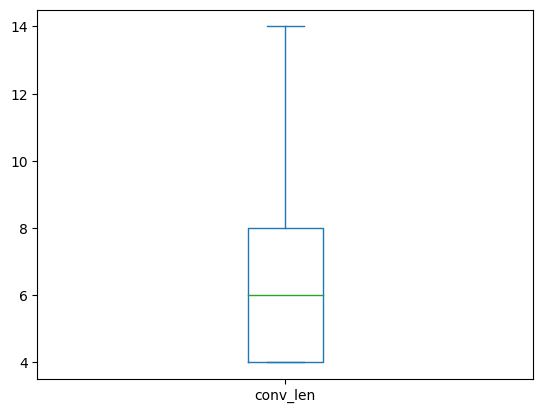

In [10]:
df["conv_len"] = df["conversations"].apply(len)

# box plot of conversation length
_ = df["conv_len"].plot.box()

In [11]:
transformers_token_counter = TransformersTokenCounter("mistralai/Mistral-7B-Instruct-v0.2")

def count_tokens(conversations: list):
    total_tokens = 0
    for conversation in conversations:
        total_tokens += transformers_token_counter(conversation["value"])
    return total_tokens

df["token_count"] = df["conversations"].progress_apply(count_tokens)

100%|██████████| 23107/23107 [00:46<00:00, 494.72it/s]


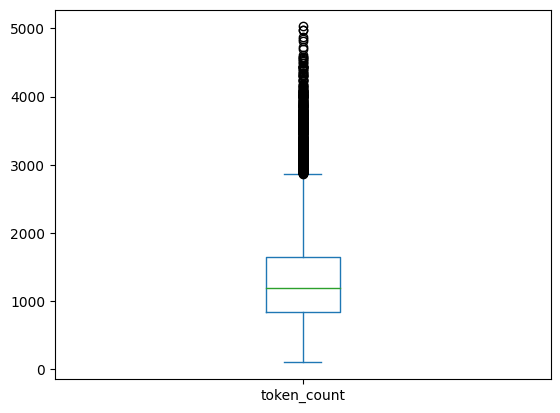

In [12]:
# box plot of token_count
_ = df["token_count"].plot.box()

In [13]:
df.drop("conv_len", axis=1, inplace=True)
df.drop("token_count", axis=1, inplace=True)
df

,prompt_id,conversations
0,9fb649a870769f4881c647d20d178656f67fc881b2dc0b...,"[{'from': 'human', 'value': 'How does the auth..."
1,26afb4f9bffc82fbbfdcaa8f0eec0833780e411799dcee...,"[{'from': 'human', 'value': 'Rice tolerance to..."
2,3ab0d0c24777248cbc4aa33971d34e8de9393db1ea0cc1...,"[{'from': 'human', 'value': 'Write a free vers..."
3,5dac3c072ba477af9ed0c71a31a806f307d7ea839a7977...,"[{'from': 'human', 'value': 'Compose a speech ..."
4,b750ea229635aa6683e0018abd17f92804376c1b0c474d...,"[{'from': 'human', 'value': 'Write a historica..."
...,...,...
23105,cd4db4c670afc4a0c49d27e75f9f8af371f067bdf3beac...,"[{'from': 'human', 'value': 'Please outline th..."
23106,499ddc7d5b7b065bd1ac5ea0e80c23cc7e73bacabd8b2b...,"[{'from': 'human', 'value': 'Who are some less..."
23107,b0d90e7abab1ec2d1a5513a369a84129564f689f7890d0...,"[{'from': 'human', 'value': 'The fear that mer..."
23108,735401bda405ea21fa8b8ba6bf45d6dd8431b8384870dd...,"[{'from': 'human', 'value': 'Provide a step-by..."


In [14]:
df.to_parquet("./data/ultrachat_200k_test_sft_convert.parquet", compression="gzip", index=False)